In [1]:
# Load in the python script containing the same code as the load the data notebook
%run loadData.py
# now we can access train, dev, and test
# along with trainSents, devSents testSents

In [2]:
# Shim names for later clean

train_question_set = train
train_document_set = trainSents

dev_question_set = dev
dev_document_set = devSents

test_question_set = test
test_document_set = testSents

In [3]:
rapid_size = 1

rapid_question_set = train_question_set[:rapid_size]
rapid_document_set = train_document_set[:rapid_size]

In [4]:
# Shim for easier name spacing

DATA = {
    "rapid" : {
            "question_set": rapid_question_set,
            "document_set": rapid_document_set,
    },
    "train" : {
            "question_set": train_question_set,
            "document_set": train_document_set,
    },
    "dev" : {
            "question_set": dev_question_set,
            "document_set": dev_document_set,
    },
    "test" : {
            "question_set": test_question_set,
            "document_set": test_document_set,
    }    
}

In [5]:
# Imports

import pprint
pp = pprint.PrettyPrinter(indent=4)

import nltk
from nltk.corpus import stopwords

from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

from string import punctuation  

import re
import pickle
import os

import csv

from collections import defaultdict


In [6]:
# Core functions

classifier = './stanford/classifiers/english.all.3class.distsim.crf.ser.gz'
jar = './stanford/stanford-ner.jar'

sTagger = StanfordNERTagger(classifier,jar)

punct_tokens = set(punctuation)
extra_tokens = set(["what", "where", "how", "when", "who"])

stop_words = set(stopwords.words('english'))

filter_tokens = extra_tokens.union(punct_tokens).union(stop_words)

In [7]:
location = ['where','what place',u'where is', u'what country',u'along with', u'where are',u'on what', u'what city', u'in the', u'where did','where']
number = [u'how many',u'how much','when','what year',u'when did', u'what year', u'when was',u'how long',u'when were', 'when']
person = [u'who was', u'who is', u'which contestant',u'who wrote', u'who said', u'who did', u'who has', u'who played','who','whom','who',]

In [8]:
def getQuestionType(question):
    
    # fix: speed up
    
    question = question.lower()
    
    for ele in person:
        if ele in question:
            return 'PERSON'
    for ele in  location:                       
        if ele in question:
            return 'LOCATION'
    for ele in  number:  
        if ele in question:
            return 'NUMBER'
    return 'O'

In [9]:
# Shim function for later clean

def getStanfordTagging(datasetName):
    fnameTrain = './preCompTags/stanfordTaggedTrain.txt'
    fnameDev = './preCompTags/stanfordTaggedDev.txt'
    fnameTest = './preCompTags/stanfordTaggedTest.txt'
    
    theFilePath = ''
    theSents = []
    if (datasetName == 'train'):
        theFilePath = fnameTrain
        theSents = trainSents
    elif (datasetName == 'dev'):
        theFilePath = fnameDev
        theSents = devSents
    elif (datasetName == 'test'):
        theFilePath = fnameTest
        theSents = testSents
    else :
        raise ValueError('Incorrect datasetName: ' + datasetName + ', choose from - "train", "dev", "test" ') 
    if (os.path.exists(theFilePath)):
        with open(theFilePath, "rb") as fp:
            stanfordTags = pickle.load(fp)
            return stanfordTags
    
    else :
        #Need to create taggings!
        taggedSentsList = []
        for sents in theSents:
            tokenisedSents = [word_tokenize(sent) for sent in sents]
            classifiedSents = sTagger.tag_sents(tokenisedSents)
            taggedSentsList.append(classifiedSents)
        #And save them
        with open(theFilePath, "wb") as fp: 
            pickle.dump(taggedSentsList, fp)
        return taggedSentsList

In [10]:
tagged_train_set = getStanfordTagging('train')
tagged_dev_set = getStanfordTagging('dev')
tagged_test_set = getStanfordTagging('test')

In [11]:
tagged_rapid_set = tagged_train_set[:rapid_size]

In [12]:
# Shim for easier name spacing

DATA["rapid"]["tagged_set"] = tagged_rapid_set
DATA["train"]["tagged_set"] = tagged_train_set
DATA["dev"]["tagged_set"] = tagged_dev_set
DATA["test"]["tagged_set"] = tagged_test_set

In [13]:
# From: WSTA_N10_word_vectors

import gensim
from nltk.data import find

word2vec_sample = str(find('models/word2vec_sample/pruned.word2vec.txt'))
word2vec_model = gensim.models.Word2Vec.load_word2vec_format(word2vec_sample, binary=False) # Use this if newer gensim: gensim.models.KeyedVectors.load_word2vec_format(word2vec_sample, binary=False)

In [14]:
# Preprocessing tuning functions

# Follow lemmatize function from guide notebook: WSTA_N1B_preprocessing.ipynb
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
word_tokenizer = nltk.tokenize.WordPunctTokenizer() #word_tokenize #tokenize.regexp.WordPunctTokenizer()

def lemmatize(word):
    lemma = lemmatizer.lemmatize(word,'v')
    if lemma == word:
        lemma = lemmatizer.lemmatize(word,'n')
    return lemma

def pre_process_tf_idf(line):
    tokenized_sentence = word_tokenizer.tokenize(line.lower())
    lemmatized_sentence = [lemmatize(token) for token in tokenized_sentence]
    filtered_sentence = [token for token in lemmatized_sentence if token not in filter_tokens]
    return filtered_sentence

In [15]:
# Core functions

def vectorize_documents(text_documents):

    vectorizer = TfidfVectorizer(stop_words='english', tokenizer=pre_process_tf_idf)
    vector_documents = vectorizer.fit_transform(text_documents)
    
    return [vector_documents, vectorizer]

def vectorize_query(vectorizer, text_query):
    return vectorizer.transform([text_query])

def process_neighbours(vector_documents):
    
    neighbours = NearestNeighbors(1, algorithm="brute", metric="cosine")
    neighbours.fit(vector_documents)
    
    return neighbours

def closest_document(neighbours, vector_query):

    result = neighbours.kneighbors(vector_query, 1, return_distance=True)

    result_index = result[1][0][0]
    result_distance = result[0][0][0]
    
    return [result_distance, result_index]

def closest_documents(neighbours, vector_query, n):

    result = neighbours.kneighbors(vector_query, n, return_distance=True)

    result_indices = result[1][0]
    result_distances = result[0][0]
    
    return sorted(zip(result_indices, result_distances), key=lambda x: x[1])

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, datasets    
from sklearn import cross_validation 
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB




In [17]:
def check_results(predictions, classifications):
    print "Accuracy: ", accuracy_score(classifications, predictions)
    print classification_report(classifications, predictions)

In [18]:
def train_model(name, data) :

    vec = DATA[name]["X_vec"]
    X = DATA[name]["X"]
    Y = DATA[name]["Y"]

    clf = linear_model.LogisticRegression(C=1e5)
#     clf = AdaBoostClassifier(n_estimators=100)
#     clf = RandomForestClassifier(n_estimators=10)
    #clf = svm.SVC()
#     clf = GaussianNB()
    
    print "Model: ", clf
    
    print
    print "Data Slice: "
    print
    print "Shape X/Y: ", X.shape, Y.shape
#     print "Types X: ", vec.get_feature_names() 
    print "Example X: ", X[0]
    print "Example Y: ", Y[0]
    print
    print "Training model..."
    
    clf.fit(X,Y)
    
    print "Cross validating..."

    predictions = cross_validation.cross_val_predict(clf, X, Y, cv=10)
    
    print
    print "Model results: "
    print

    check_results(predictions, Y)
    
    return clf

In [19]:
def f_w2v(x):
    return word2vec_model.vocab.get(x) is not None

In [20]:
def process_sentences(sentences):
    
    vector_sentences, vectorizer = vectorize_documents(sentences)
    analyze = vectorizer.build_analyzer()
    neighbours = process_neighbours(vector_sentences)
       
    return {
            "vector_sentences": vector_sentences,
            "vectorizer": vectorizer,
            "analyze": analyze,
            "neighbours": neighbours
           }

In [21]:
def process_feature(candidate_result, question, question_text_vector, analyze, sentences, y_sup=False):
    
    text_query = question["question"]
        
    result_index = candidate_result[0]
    result_distance = candidate_result[1]    
    
    result_text_vector = set(filter(f_w2v, analyze(sentences[result_index])))

    if len(question_text_vector) > 0 and len(result_text_vector) > 0:

        current_w2v_simil = word2vec_model.n_similarity(question_text_vector, result_text_vector)
        question_type = getQuestionType(text_query)

        new_x = {
                "tf-idf": result_distance, 
                "w2v": current_w2v_simil,
                "qtype": question_type,
                "len_sent": len(sentences[result_index])
        }

        new_y = None
        
        if not y_sup:
            new_y = int(result_index == question["answer_sentence"])

        return [new_x, new_y]
    
    else:
        
        return None
    

In [22]:
def process_enhancement(question, neighbours, vector_query, analyze, sentences, y_sup=False):
    
    text_query = question["question"]
    question_text_vector = set(filter(f_w2v, analyze(text_query)))
    
    candidate_results = closest_documents(neighbours, vector_query, 5)
    features = filter(None, [process_feature(x, question, question_text_vector, analyze, sentences, y_sup) for x in candidate_results])
    
    return {
        "candidate_results": candidate_results,
        "features": features
    }
    

In [23]:
def process_query(question, vectorizer, neighbours, analyze):
    
    text_query = question["question"]
    vector_query = vectorize_query(vectorizer, text_query)

    result_distance, result_index = closest_document(neighbours, vector_query)
    
    return {
            "vector_query": vector_query,
            "result_distance": result_distance,
            "result_index": result_index
           }

In [24]:
def recursive_default_dict():
    return defaultdict(recursive_default_dict)

In [31]:
def generate_part_a_output(name, data, args):
    
    cached = args.get("cached")
    
    use_enhancement = args.get("use_enhancement")
    train_enhancement = args.get("train_enhancement")
    
    enhancement_dataset = args.get("enhancement_dataset")
    
    y_sup = args.get("y_sup")
    
    question_set = data[name]["question_set"]
    document_set = data[name]["document_set"]
    
    part_a_output = []
    X = []
    Y = []
    
    index_to_x = {}
    
    cache_dict = None
    
    if cached:
        
        cache_dict = data[name]["part_a_cache_dict"]
        
        x_best = cache_dict.get("X_best")
        
        if x_best == None:
            cache_dict["X_best"] = recursive_default_dict()
        
#         X = data[name]["X"]
#         Y = data[name]["Y"]        
        
    else:
        
        cache_dict = {}
        
        cache_dict["sen_cache"] = []
        
        cache_dict["query_cache"] = []
        
        cache_dict["X_best"] = recursive_default_dict()
        
        if use_enhancement:
            
            cache_dict["enhancement_cache"] = []
                
        
    for i, questions in enumerate(question_set):
        
        sentences = document_set[i]
        
        sen_cache = None

        if cached:
            
            sen_cache_item = cache_dict["sen_cache"][i]
        
        else:
            
            sen_cache_item = process_sentences(sentences)
            cache_dict["sen_cache"].append(sen_cache_item)
            
            cache_dict["query_cache"].append([])
            
            if use_enhancement:
                
                cache_dict["enhancement_cache"].append([])

        for j, question in enumerate(questions):
            
            query_cache_item = None
            result_index = None
            
            if cached:
                
                query_cache_item = cache_dict["query_cache"][i][j]
                result_index = query_cache_item["result_index"]
                
                if use_enhancement:
                    
                    enhancement_cache_item = cache_dict["enhancement_cache"][i][j]

                    model = data[enhancement_dataset]["model"]
                    vec = data[enhancement_dataset]["X_vec"]

                    candidate_results = enhancement_cache_item["candidate_results"]
                    new_xs = [feature[0] for feature in enhancement_cache_item["features"]]

                    if len(new_xs) > 0:

                        new_features = vec.transform(new_xs) #.toarray()

                        prob_ys = model.predict_proba(new_features)
                        best_y_index = np.argmax(prob_ys[:, 1])
                        
                        cache_dict["X_best"][i][j] = new_xs[best_y_index]

                        result_index = candidate_results[best_y_index][0]
                
            else:
                
                query_cache_item = process_query(question, sen_cache_item["vectorizer"], sen_cache_item["neighbours"], sen_cache_item["analyze"])
                cache_dict["query_cache"][i].append(query_cache_item)
                
                result_index = query_cache_item["result_index"]
                
                if use_enhancement:
                    
                    enhancement_cache_item = process_enhancement(question, sen_cache_item["neighbours"], query_cache_item["vector_query"], sen_cache_item["analyze"], sentences, y_sup)
                    cache_dict["enhancement_cache"][i].append(enhancement_cache_item)                    
                
                if train_enhancement:

                    new_xs = [feature[0] for feature in enhancement_cache_item["features"]]
                    new_ys = [feature[1] for feature in enhancement_cache_item["features"]]

                    X += new_xs
                    Y += new_ys
            
            result = {
                "set_index" : i,
                "question_index" : j,
                "sentence_index" : result_index
            }

            part_a_output.append(result)
            
#             if j > 1:
#                 break
                
#         if i > 1:
#             break
            
    if not cached:
        
        data[name]["part_a_cache_dict"] = cache_dict
        
        if train_enhancement:
        
            vec = DictVectorizer()                
            X = vec.fit_transform(X) #.toarray()
            Y = np.array(Y)

            data[name]["X_vec"] = vec
            data[name]["X"] = X
            data[name]["Y"] = Y

            print "Shape X/Y: ", data[name]["X"].shape, data[name]["Y"].shape
#             print "Types X: ", vec.get_feature_names()        
            print "Example X: ", X[0]
            print "Example Y: ", Y[0]        
        
    return part_a_output

In [32]:
def process_part_a(name, data, args):
    
    data[name]["a_output_answer_set"] = generate_part_a_output(name, data, args)
    
    gen_model = args.get("gen_model")
    
    if gen_model:
        data[name]["model"] = train_model(name, data)
    
    print
    print "Part A Output: "
    print
    pp.pprint(data[name]["a_output_answer_set"][:rapid_size])
    print

In [33]:
# Shim function for later clean

def evaluate_retrieval(name, data, args):
    
    question_set = data[name]["question_set"]
    a_output_answer_set = data[name]["a_output_answer_set"]
    
    correct = []
    wrong = []
    
    for result_a in a_output_answer_set:
        
        question = question_set[result_a["set_index"]][result_a["question_index"]]
        
        answer_sentence = question["answer_sentence"]
        predicted_answer_sentence = result_a["sentence_index"]
        
        if answer_sentence == predicted_answer_sentence:
            correct.append(result_a)
        else:
            wrong.append(result_a)
        
#         break
            
    return (correct, wrong)

In [34]:
def process_generic(name, data, process_type, process_func, args):

    (correct, wrong) = process_func(name, data, args)
    
    data[name][process_type + "_correct"] = correct
    data[name][process_type + "_wrong"] = wrong
#     data[name][process_type + "_full"] = full
    
    total = len(correct) + len(wrong)
    avg = len(correct) * 1.0 / total
    
    print process_type.capitalize() + " Correct: ", len(correct)
    print process_type.capitalize() + " Wrong: ", len(wrong)
    print process_type.capitalize() + " Total: ", total
    print process_type.capitalize() + " Overall Average %: ", avg

In [35]:
def process_retrieval(name, data, stats=False, args={}):
    print "Processing retrieval: ", name
    process_part_a(name, data, args)
    if stats:
        process_generic(name, data, "retrieval", evaluate_retrieval, args)
        
    print

In [36]:
process_retrieval("rapid", DATA, True, {"cached" : False, 
                                        "train_enhancement": True,
                                        "use_enhancement": True,
                                        "enhancement_dataset": "rapid",
                                        "y_sup": False,
                                        "gen_model": True})                                        

process_retrieval("rapid", DATA, True, {"cached" : True, 
                                        "train_enhancement": False,
                                        "use_enhancement": False,
                                        "enhancement_dataset": "rapid",
                                        "y_sup": False,
                                        "gen_model": True})

# process_retrieval("rapid", DATA, True, {"cached" : True, 
#                                         "train_enhancement": False,
#                                         "use_enhancement": True,
#                                         "enhancement_dataset": "rapid",
#                                         "y_sup": False,
#                                         "gen_model": False})

# process_retrieval("rapid", DATA, True, {"cached" : True, 
#                                         "train_enhancement": False,
#                                         "use_enhancement": False,
#                                         "enhancement_dataset": "train",
#                                         "y_sup": False,
#                                         "gen_model": False})

Processing retrieval:  rapid
Shape X/Y:  (2010, 7) (2010,)
Example X:  [ 41.           0.           1.           0.           0.           0.81081881
   0.55402556]
Example Y:  0
Model:  LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Data Slice: 

Shape X/Y:  (2010, 7) (2010,)
Example X:  [ 41.           0.           1.           0.           0.           0.81081881
   0.55402556]
Example Y:  0

Training model...
Cross validating...

Model results: 

Accuracy:  0.876119402985
             precision    recall  f1-score   support

          0       0.89      0.98      0.93      1740
          1       0.60      0.23      0.33       270

avg / total       0.85      0.88      0.85      2010


Part A Output: 

[{   'question_index': 0, 'sentence_index': 149, 'set_index': 

In [77]:
# process_retrieval("dev", DATA, True, {"cached" : False, 
#                                         "train_enhancement": True,
#                                         "use_enhancement": True,
#                                         "enhancement_dataset": "dev",
#                                         "y_sup": False,
#                                         "gen_model": True})                                      

# process_retrieval("dev", DATA, True, {   "cached" : True, 
#                                         "train_enhancement": False,
#                                         "use_enhancement": False,
#                                         "enhancement_dataset": "dev",
#                                         "y_sup": False,
#                                         "gen_model": True})                                      

process_retrieval("dev", DATA, True, {   "cached" : True, 
                                        "train_enhancement": False,
                                        "use_enhancement": True,
                                        "enhancement_dataset": "dev",
                                        "y_sup": False,
                                        "gen_model": False})    

# process_retrieval("dev", DATA, True, {   "cached" : True, 
#                                         "train_enhancement": False,
#                                         "use_enhancement": True,
#                                         "enhancement_dataset": "train",
#                                         "y_sup": False,
#                                         "gen_model": False})    

Processing retrieval:  dev

Part A Output: 

[{   'question_index': 0, 'sentence_index': 71, 'set_index': 0}]

Retrieval Correct:  5259
Retrieval Wrong:  3204
Retrieval Total:  8463
Retrieval Overall Average %:  0.621410847217



In [127]:
process_retrieval("train", DATA, True, {"cached" : False, 
                                        "train_enhancement": True,
                                        "use_enhancement": True,
                                        "enhancement_dataset": "train",
                                        "gen_model": True})                                     

# process_retrieval("train", DATA, True, {"cached" : True, 
#                                         "train_enhancement": False,
#                                         "use_enhancement": False,
#                                         "enhancement_dataset": "train",
#                                         "y_sup": False,
#                                         "gen_model": True})                                        


# process_retrieval("train", DATA, True, {"cached" : True, 
#                                         "train_enhancement": False,
#                                         "use_enhancement": True,
#                                         "enhancement_dataset": "train",
#                                         "y_sup": False,
#                                         "gen_model": False})   

Processing retrieval:  train
Shape X/Y:  (346425, 7) (346425,)
Example X:  [ 41.           0.           1.           0.           0.           0.81081881
   0.55402556]
Example Y:  0
Model:  LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Data Slice: 

Shape X/Y:  (346425, 7) (346425,)
Example X:  [ 41.           0.           1.           0.           0.           0.81081881
   0.55402556]
Example Y:  0

Training model...
Cross validating...

Model results: 

Accuracy:  0.884277982247
             precision    recall  f1-score   support

          0       0.90      0.97      0.93    288180
          1       0.74      0.48      0.58     58245

avg / total       0.87      0.88      0.87    346425


Part A Output: 

[{   'question_index': 0, 'sentence_index': 149, 'set_

In [ ]:
# process_retrieval("test", DATA, False, {"cached" : False, 
#                                         "train_enhancement": False,
#                                         "use_enhancement": True,
#                                         "enhancement_dataset": "dev",
#                                         "y_sup": True})                                       

# process_retrieval("test", DATA, False, {"cached" : True, 
#                                         "train_enhancement": False,
#                                         "use_enhancement": False,
#                                         "enhancement_dataset": "dev",
#                                         "y_sup": True})                                       

process_retrieval("test", DATA, False, {"cached" : True, 
                                        "train_enhancement": False,
                                        "use_enhancement": True,
                                        "enhancement_dataset": "dev",
                                        "y_sup": True})                                       

In [134]:
process_retrieval("test", DATA, False, {"cached" : False, 
                                        "train_enhancement": False,
                                        "use_enhancement": True,
                                        "enhancement_dataset": "train",
                                        "y_sup": True})                                       

# process_retrieval("test", DATA, False, {"cached" : True, 
#                                         "train_enhancement": False,
#                                         "use_enhancement": False,
#                                         "enhancement_dataset": "train",
#                                         "y_sup": True})                                       

process_retrieval("test", DATA, False, {"cached" : True, 
                                        "train_enhancement": False,
                                        "use_enhancement": True,
                                        "enhancement_dataset": "train",
                                        "y_sup": True})                                       

Processing retrieval:  test

Part A Output: 

[{   'question_index': 0, 'sentence_index': 283, 'set_index': 0}]


Processing retrieval:  test

Part A Output: 

[{   'question_index': 0, 'sentence_index': 353, 'set_index': 0}]




In [37]:
# Shim function for later clean

# Thanks for this list to save me typing it : http://stackoverflow.com/questions/493174/is-there-a-way-to-convert-number-words-to-integers\n",
numInWords = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"
       , "hundred", "thousand", "million", "billion", "trillion"]

punctuation = ["''",'``','(','.',':', ',',')']


months = ["January","February","March","April","May","June","July","August","September","October","November","December"]

def isPunctuation(word):
    return word in punctuation

def isCapitalised (word):
    if len(word) == 0:
        return False
    return word[0].isupper()

# Obtained from training data
postUnits = [u'%', u'century', u'years', u'percent', u'years ago', u'days', u'months', u'km', u'hours', u'times', u'inches', u'\xb0C', u'minutes', u'acres', u'\xb0F', u'weeks', u'people', u'sq mi', u'mi', u'ft', u'feet', u'metres', u'mm', u'square miles', u'miles', u'pm', u'per cent', u'year', u'copies', u'yuan', u'men', u'square feet', u'third', u'kilometres', u'nm', u'tonnes', u'species', u'decades', u'barrels', u'tons', u'largest', u'centuries', u'km2']
preUnits = [u'$',u'around', u'late', u'early', u'nearly', u'since', u'approximately', u'number']

# Returns true if the word represents a number\n",
def isNumber(word):
    pattern = ".?(\\d)+((,|.)(\\d)+)*"
    if re.match(pattern,word) :
        return True
    if word.lower() in numInWords:
        return True
    if word in months:
        return True
    return False

def isStopWord(word):
    return word.lower() in stop_words

In [38]:
grammar = """ ANS: {<JJ>?<N.*>*}
                   {<DT>?<N.*>*}
                   }<UH|POS|VB|VBG|RP|DT|MD|PRP$|TO|RB|JJS|PDT|IN|PRP|VBP|VBN|RBS|WRB|WP|EX|VBZ|WDT|VBD>{
                    """
cp = nltk.RegexpParser(grammar) 

def chunk(words):
    tokenWS = nltk.pos_tag(nltk.word_tokenize(words))
    chunks =  cp.parse(tokenWS)
    possAnswers = []
    for subtree in chunks.subtrees():
        if subtree.label() == 'ANS':
            possAnswers.append((' '.join(word for word, pos in subtree.leaves()),'O'))
    possAnswers.append(("Nope", "CRAP")) # To ensure nothing has 0 tags
    return possAnswers    

In [39]:
def add_non_chunked_words_as_single_tags(words):
    chunked_output = chunk(words)
    token_words = nltk.pos_tag(nltk.word_tokenize(words))
    if len(chunked_output) == 0:
        chunked_words = ["DEREKWANG"]
    else:
        chunked_words = [nltk.word_tokenize(word_tag_pair[0]) for word_tag_pair in chunked_output ]    
    all_word_tags = []
    
    current_chunk_index = 0
    current_chunk_word = 0
    current_chunk_list = chunked_words[0]
    
    for word_tag_pair in token_words:
        word = word_tag_pair[0]
        if word == current_chunk_list[current_chunk_word]:
            # Need to move onto next word
            if current_chunk_word == len(current_chunk_list) - 1:
                # last word in this current chunk
                all_word_tags.append(chunked_output[current_chunk_index])
                current_chunk_index += 1
                current_chunk_word = 0
                if current_chunk_index == len(chunked_words):
                    current_chunk_list = ["NOPE"]
                else:
                    current_chunk_list = chunked_words[current_chunk_index]
            else :
                current_chunk_word += 1
        else :
            # Need to add word, as it's not in a chunk :(
            all_word_tags.append((word,'O'))
    return all_word_tags


In [40]:
# Shim function for later clean

def slow_refine_word_tags(taggedWordList):
    newWordTags = []
    for (word, tag) in taggedWordList:
        if (tag == 'ORGANIZATION'):
            tag = 'O'
        if (tag == 'O'):
            #Might be a number
            if isNumber(word):
                tag = 'NUMBER'
            elif word in preUnits:
                tag = 'PRENUM'
            elif isPunctuation(word):
                tag = 'PUNC'
            elif word in postUnits:
                tag = 'POSTNUM'
            elif isCapitalised(word):
                tag = "OTHERCAP"
        newWordTags.append((word, tag))
    
    newWordTags = combineTags (newWordTags)
    other_processed_tags = process_others(newWordTags)
    return other_processed_tags
        
def combineTags(wordTags):
    
    newTags = []
    prevWord = wordTags[0][0]
    prevTag = wordTags[0][1]
    
    for (word, tag) in wordTags[1:]:
        if tag == 'NUMBER' and prevTag == 'PRENUM':
            prevTag = 'NUMBER'
        elif prevTag == 'PRENUM':
            prevTag = 'O'
        if tag == 'POSTNUM' and prevTag == "NUMBER":
            tag = "NUMBER"
        elif tag == "POSTNUM":
            tag = "O"
        newTags.append((prevWord, prevTag))
        prevWord = word
        prevTag = tag
    newTags.append((prevWord, prevTag))
        
    newNewTags = []
    prevWord = newTags[0][0]
    prevTag = newTags[0][1]
    if (prevTag == "OTHERCAP" and newTags[1][1] != "OTHERCAP"):
        prevTag = "O"
        
    for (word, tag) in newTags[1:]:
#         print tag, prevTag
        if tag == prevTag :
            if word == '%':
                prevWord += word
            else :
                if prevWord == '$':
                    prevWord += word
                else :
                    prevWord += ' ' + word
        else :
            newNewTags.append((prevWord, prevTag))
            prevWord = word
            prevTag = tag
            
    newNewTags.append((prevWord, prevTag))
    
    return newNewTags

def process_others(words_with_tags):
    new_taggings = []
    for (words, tag) in words_with_tags:
        if tag == 'O':
            chunk_results = add_non_chunked_words_as_single_tags(words)
            for (word,tag) in chunk_results:
                new_taggings.append((word, tag))
            #new_taggings.append((words,tag))
        else :
            new_taggings.append((words, tag))
    return new_taggings
        

In [41]:

# Shim function for later clean

def fast_refine_word_tags(taggedWordList):
    newWordTags = []
    for (word, tag) in taggedWordList:
        if (tag == 'ORGANIZATION'):
            tag = 'O'
        if (tag == 'O'):
            #Might be a number
            if isNumber(word):
                tag = 'NUMBER'
            elif isCapitalised(word):
                tag = 'OTHERCAP'
            elif word in preUnits:
                tag = 'PRENUM'
            elif word in postUnits:
                tag = 'POSTNUM'
            elif isStopWord(word):
                tag = 'STOPWORD'
            elif isPunctuation(word):
                tag = 'PUNC'

        newWordTags.append((word, tag))
    
    newWordTags = combineTags (newWordTags)
    return newWordTags
        
def combineTags(wordTags):
    
    newTags = []
    prevWord = wordTags[0][0]
    prevTag = wordTags[0][1]
    
    for (word, tag) in wordTags[1:]:
        if tag == 'NUMBER' and prevTag == 'PRENUM':
            prevTag = 'NUMBER'
        elif prevTag == 'PRENUM':
            prevTag = 'O'
        if tag == 'POSTNUM' and prevTag == "NUMBER":
            tag = "NUMBER"
        elif tag == "POSTNUM":
            tag = "O"
        newTags.append((prevWord, prevTag))
        prevWord = word
        prevTag = tag
    newTags.append((prevWord, prevTag))
    
#     print newTags
    
    newNewTags = []
    prevWord = newTags[0][0]
    prevTag = newTags[0][1]
    if (prevTag == "OTHERCAP"):
        prevTag = "O"
        
    for (word, tag) in newTags[1:]:
#         print tag, prevTag
        if tag == prevTag :
            prevWord += ' ' + word
        else :
            newNewTags.append((prevWord, prevTag))
            prevWord = word
            prevTag = tag
            
    newNewTags.append((prevWord, prevTag))
    
    return newNewTags

In [42]:
def generate_part_b_output(name, data, args):
    
    question_set = data[name]["question_set"]
    a_output_answer_set = data[name]["a_output_answer_set"]
    tagged_set = data[name]["tagged_set"]
    
    refine_func = args.get("refine_func")
    
    part_b_output = []
    
    for result_a in a_output_answer_set:
        
        stanford_tags = tagged_set[result_a["set_index"]][result_a["sentence_index"]]
        
        filtered_tags = refine_func(stanford_tags)
        
        question = question_set[result_a["set_index"]][result_a["question_index"]]["question"]
        
        result_b = {
            "set_index"  : result_a["set_index"],
            "question_index" : result_a["question_index"],
            "sentence_index" : result_a["sentence_index"],
            "candidates" : filtered_tags
        }
        
        part_b_output.append(result_b)
        
    return part_b_output

In [43]:
def process_part_b(name, data, args):
    
    data[name]["b_output_answer_set"] = generate_part_b_output(name, data, args)
    
    print
    print "Part B Output: "
    pp.pprint(data[name]["b_output_answer_set"][:rapid_size])
    print    

In [44]:
# Shim function for later clean

def evaluate_ner(name, data, args):
    
    question_set = data[name]["question_set"]
    b_output_answer_set = data[name]["b_output_answer_set"]
    
    correct = []
    wrong = []
    
    for result_b in b_output_answer_set:
        
        answer = question_set[result_b["set_index"]][result_b["question_index"]]["answer"]
        
        possible_candidates = result_b["candidates"]
        
        answer_exists_in_candidates = False
        
        for candidate in possible_candidates:
            
            candidate_string = candidate[0]
            
            if candidate_string == answer:
                
                answer_exists_in_candidates = True
                
                break
        
        if answer_exists_in_candidates:
            correct.append(result_b)
        else :
            wrong.append(result_b)
            
    return (correct, wrong)

In [45]:
def process_ner(name, data, stats=False, args={}):
    print "Processing ner: ", name
    process_part_b(name, data, args)
    if stats:
        process_generic(name, data, "ner", evaluate_ner, args)
        
        correct_ner = len(data[name]["ner_correct"])
        correct_ret = len(data[name]["retrieval_correct"])
        
        avg = correct_ner * 1.0 / correct_ret
        
        print "ner".capitalize() + " Correct Average of Previous %: ", avg
    print

In [46]:
process_ner("rapid", DATA, True, {"refine_func": slow_refine_word_tags})

Processing ner:  rapid

Part B Output: 
[   {   'candidates': [   (u'They', 'O'),
                          (u'had', 'O'),
                          (u'a', 'O'),
                          (u'playing time', 'O'),
                          (u'of', 'O'),
                          (u'eight minutes', 'NUMBER'),
                          (u'.', 'PUNC')],
        'question_index': 0,
        'sentence_index': 149,
        'set_index': 0}]

Ner Correct:  74
Ner Wrong:  330
Ner Total:  404
Ner Overall Average %:  0.183168316832
Ner Correct Average of Previous %:  0.474358974359



In [131]:
process_ner("dev", DATA, True, {"refine_func": fast_refine_word_tags})

Processing ner:  dev

Part B Output: 
[   {   'candidates': [   (u'Infrared', 'O'),
                          (u'is', 'STOPWORD'),
                          (u'used', u'O'),
                          (u'in', 'STOPWORD'),
                          (u'night vision equipment', u'O'),
                          (u'when there is', 'STOPWORD'),
                          (u'insufficient visible light', u'O'),
                          (u'to', 'STOPWORD'),
                          (u'see', u'O'),
                          (u'.', 'PUNC')],
        'question_index': 0,
        'sentence_index': 71,
        'set_index': 0}]

Ner Correct:  2606
Ner Wrong:  5857
Ner Total:  8463
Ner Overall Average %:  0.307928630509
Ner Correct Average of Previous %:  0.495531469861



In [128]:
process_ner("train", DATA, True, {"refine_func": fast_refine_word_tags})

Processing ner:  train

Part B Output: 
[   {   'candidates': [   (u'They', 'O'),
                          (u'had a', 'STOPWORD'),
                          (u'playing time', u'O'),
                          (u'of', 'STOPWORD'),
                          (u'eight minutes', 'NUMBER'),
                          (u'.', 'PUNC')],
        'question_index': 0,
        'sentence_index': 149,
        'set_index': 0}]

Ner Correct:  21249
Ner Wrong:  48910
Ner Total:  70159
Ner Overall Average %:  0.302869197109
Ner Correct Average of Previous %:  0.486480917603



In [140]:
process_ner("test", DATA, False, {"refine_func": slow_refine_word_tags})

Processing ner:  test

Part B Output: 
[   {   'candidates': [   (u'The', 'O'),
                          (u'Crimean War', 'OTHERCAP'),
                          (u'marked', 'O'),
                          (u'the', 'O'),
                          (u'ascendancy', 'O'),
                          (u'of', 'O'),
                          (u'France', u'LOCATION'),
                          (u'to', 'O'),
                          (u'the', 'O'),
                          (u'position', 'O'),
                          (u'of', 'O'),
                          (u'pre-eminent power', 'O'),
                          (u'on', 'O'),
                          (u'the', 'O'),
                          (u'Continent', 'OTHERCAP'),
                          (u',', 'PUNC'),
                          (u':411', 'NUMBER'),
                          (u'the', 'O'),
                          (u'continued decline', 'O'),
                          (u'of', 'O'),
                          (u'the', 'O'),
                

In [79]:
# First, answers whose content words all appear in the question should be ranked lowest.

def first_filter(question, answer_entities):
   
    ranked_list = []
    
    question = set(pre_process_tf_idf(question))
    
#     print question
#     print
    
    for entity in answer_entities:

        raw_span = entity[0]
        span_tag = entity[1]
        
        set_span = set(pre_process_tf_idf(raw_span))
        
        if span_tag != "O" and span_tag != "STOPWORD" and span_tag !="PUNC":
            
            if set_span.issubset(question):
                
                ranked_list.append([entity, 1])
#                 print "IN", raw_span, span_tag, set_span, question
                
            else:
                
                ranked_list.append([entity, 2])
#                 print "OUT", raw_span, span_tag, set_span, question
    
    return sorted(ranked_list, key=lambda x: x[1], reverse=True)

In [80]:
# First, answers whose content words all appear in the question should be ranked lowest.

def first_filter_object(question, answer_entities):
   
    ranked_list = []
    
    question = set(pre_process_tf_idf(question))
    
#     print question
#     print
    
    for entity in answer_entities:

        raw_span = entity[0]
        span_tag = entity[1]
        
        set_span = set(pre_process_tf_idf(raw_span))
        
        if span_tag != "STOPWORD" and span_tag !="PUNC": #span_tag != "O" and
            
            if span_tag == "O":
                
                if len(set_span) > 1:
                    ranked_list.append([entity, 0])
            
            elif set_span.issubset(question):
                
                ranked_list.append([entity, 1])
#                 print "IN", raw_span, span_tag, set_span, question
                
            else:
                
                ranked_list.append([entity, 2])
#                 print "OUT", raw_span, span_tag, set_span, question
    
    return sorted(ranked_list, key=lambda x: x[1], reverse=True)

In [81]:
# First, answers whose content words all appear in the question should be ranked lowest.

def first_filter_object_stop(question, answer_entities):
   
    ranked_list = []
    
    question = set(pre_process_tf_idf(question))
    
#     print question
#     print
    
    for entity in answer_entities:

        raw_span = entity[0]
        span_tag = entity[1]
        
        set_span = set(pre_process_tf_idf(raw_span))
        
        if span_tag !="PUNC": #span_tag != "O" and
            
            if span_tag == "O" or span_tag == "STOPWORD":
                
                if len(set_span) > 1:
                    
                    ranked_list.append([entity, 0])
            
            elif set_span.issubset(question):
                
                ranked_list.append([entity, 1])
#                 print "IN", raw_span, span_tag, set_span, question
                
            else:
                
                ranked_list.append([entity, 2])
#                 print "OUT", raw_span, span_tag, set_span, question
    
    return sorted(ranked_list, key=lambda x: x[1], reverse=True)

In [82]:
# Second, answers which match the question type should be ranked higher than those that don't; for this, you
# should build a simple rule-based question type classifier based on key words (e.g. questions which contain "who" are
# people).

# First, answers whose content words all appear in the question should be ranked lowest.

def second_filter(question, ranked_list):
   
    question_type = getQuestionType(question)
#     print question_type
    
    for index, answer in enumerate(ranked_list):
        
        entity_tag = answer[0][1]
        
        if entity_tag == question_type:
#             print "MATCH", answer[0], question_type, question
            ranked_list[index].append(2)
#             ranked_list[index][1] += 1
        else:
            ranked_list[index].append(1)
#             ranked_list[index][1] -= 1
            
    return ranked_list

In [83]:
def pre_process_open_class(line):
    tokenized_sentence = word_tokenizer.tokenize(line.lower())
    lemmatized_sentence = [lemmatize(token) for token in tokenized_sentence]
    filtered_sentence = [token for token in lemmatized_sentence if token not in filter_tokens]
    tagged_sent = nltk.pos_tag(lemmatized_sentence)
    final = []
       
    for word, tag in tagged_sent:
        #expand the open-class word to noun,verb,adj and adv
        if "V" in tag or "NN" in tag or 'JJ' in tag or 'RB' in tag:
#             final.append((word,tag))
            final.append(word)
            
#     print "RESULT: ", final
    return final

In [84]:
# Third, among entities of the same type, the prefered entity should be the one which is closer in the sentence to a
# closed-class word from the question.

def third_filter(question, possAnswers, ranked_list):
    
    question = pre_process_open_class(question)

    answer_sent = " ".join([x[0] for x in possAnswers])
    answer_sent = pre_process_tf_idf(answer_sent)
    raw_answer_sent = " ".join(answer_sent)
    
#     print "QUESTION: "
#     pp.pprint(question)
#     print "ANSWER: "
#     pp.pprint(answer_sent)
#     pp.pprint(raw_answer_sent)
    
    for index, answer in enumerate(ranked_list):

        span_tag = answer[0][1]
        raw_span = answer[0][0]

        proc_span = pre_process_tf_idf(raw_span)

        raw_proc_span = " ".join(proc_span)
        new_raw_proc_span = "-".join(proc_span)

        raw_answer_sent = raw_answer_sent.replace(raw_proc_span, new_raw_proc_span)
    
    answer_sent = raw_answer_sent.split(" ")
    
    avg_dict = defaultdict(float)
    
    for open_class in question:
        
        if open_class in answer_sent:
            
            open_class_locations = [i for i, x in enumerate(answer_sent) if x == open_class]
            
#             print "OPEN CLASS: ", repr(open_class)

            for index, answer in enumerate(ranked_list):

                span_tag = answer[0][1]
                raw_span = answer[0][0]

                proc_span = pre_process_tf_idf(raw_span)
                
                raw_proc_span = " ".join(proc_span)
                new_raw_proc_span = "-".join(proc_span)
                
                proc_span_locations = [i for i, x in enumerate(answer_sent) if x == new_raw_proc_span]
                
                min_dist = len(answer_sent)
                min_dist_ind = (None, None)
                
                for loc1 in proc_span_locations:
                    
                    for loc2 in open_class_locations:
                        
                        dist = abs(loc1 - loc2)
                        
                        if dist < min_dist:
                            
                            min_dist = dist
                            min_dist_ind = (loc1, loc2)
                
#                 print "PROC: ", proc_span_locations
#                 print "OPEN CLASS: ", open_class_locations                
                scale = (len(answer_sent) - min_dist) * 1.0 / len(answer_sent)
#                 print "JOINT: ", min_dist_ind, scale
                avg_dict[index] += scale
#                 ranked_list[index][1] *= scale
    
    for key, value in avg_dict.iteritems():
        ranked_list[key].append(value / len(question))

    return ranked_list

In [85]:
def reduce_rank(ranking_list):
    
    new_ranking = []
    
    for rank in ranking_list:
        
        new_rank = ( rank[1] + rank[2] )
        
        if len(rank) == 4:
             new_rank *= rank[3]
        
        new_ranking.append([rank[0], new_rank])
        
    return sorted(new_ranking, key=lambda x: x[1], reverse=True)

In [86]:
import random


In [87]:
def get_result(fourth_pass):
    top_answer = fourth_pass[0]
    predicted_answer = top_answer[0][0]    
    
    return predicted_answer

In [88]:
def multi_pass(first_filter_funcs, question, candidates, mem=None):
    
    if len(first_filter_funcs) > 0:
    
        first_pass = first_filter_funcs.pop(0)(question, candidates)

        second_pass = second_filter(question, first_pass)

        third_pass = third_filter(question, candidates, second_pass)

        fourth_pass = reduce_rank(third_pass)

        if len(fourth_pass) > 0:
            
            predicted_answer = get_result(fourth_pass)
            
            return [fourth_pass, third_pass, predicted_answer]
        else:
            return multi_pass(first_filter_funcs, question, candidates, [fourth_pass, third_pass])
    else:
        
        hits = [x for x in candidates if x[1] != "PUNC" or x[1] == "STOPWORDS"]                        
        predicted_answer = random.choice(hits)[0]
        
        return mem + [predicted_answer]

In [341]:
def build_feature(feature, rela_proc, question_proc, question_type, a_new_x):
    
#     pp.pprint(feature)    
    
    open_dist = 0.5
    
    if len(feature) > 3:
        open_dist = feature[3]
        
        
    c_feature =  {
            "answer_type": feature[0][1],
            "question_type": question_type,
            "first" : feature[1],
            "second": feature[2],
            "open_dist": open_dist,            
    }
    
#     answer_proc = feature[0][0].split(" ") #pre_process_tf_idf(feature[0][0].encode('ascii', 'ignore'))
        
#     for x in answer_proc:
        
#         if rela_proc.get(x):
            
#             relations = rela_proc[x]
            
#             for y in relations:
            
#                 for z in question_proc:
                    
#                     feature_name = "DSQ: {0} {1} {2}".format(z, y[2], y[1]).encode('ascii', 'ignore')
#                     c_feature[feature_name] = 1.0
                
#             feature_name = "DAQ: {0}, {1}".format(x, y).encode('ascii', 'ignore')
#             c_feature[feature_name] = 1.0
    
    c_feature.update(a_new_x)
    
    return c_feature

In [324]:
from nltk.parse.stanford import StanfordDependencyParser

import os
os.environ['CLASSPATH'] = 'stanford-parser-full-2016-10-31'

dep_parser = StanfordDependencyParser(model_path="./englishPCFG.ser.gz")



In [296]:
def print_tree(tree):
    print tree

In [197]:
from nltk.tree import Tree

In [224]:
tree = get_tree("This is a long sentence, it has many relations")


In [225]:
relations = []

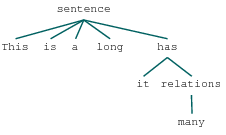

In [226]:
tree

In [223]:
tree.treepositions()

[(), (0,), (1,), (2,), (3,)]

In [242]:
dep = get_dep_tree('I shot an elephant in my sleep')
l = list(dep.triples())

In [280]:
def get_dep_tree(string):
    
    parses = [parse for parse in dep_parser.raw_parse(string.encode('ascii', 'ignore'))]
    
    if len(parses) > 0:
        return parses[0]
    else:
        return None

In [334]:
def processed_relations(string):
    
    dep = get_dep_tree(string)
    
    l = list(dep.triples())

    rela_struct = defaultdict(list)

    prune = { "CC": True, ".": True, ": True,": True, ":": True, "-LRB-": True, "-RRB-": True, "POS": True, "DT": True, "IN": True, "TO": True }

    for a in l:

        source_tuple = a[0]

        relation = a[1]

        sink_tuple = a[2]

        source_word = source_tuple[0]
        source_word_tag = source_tuple[1]

        sink_word = sink_tuple[0]
        sink_word_tag = sink_tuple[1]
        
#         print source_tuple, relation, sink_tuple

        if source_word not in prune and sink_word_tag not in prune:   
            rela_struct[source_word].append((relation, "->", sink_word))   
            rela_struct[sink_word].append((relation, "<-", source_word))                        

    return rela_struct

In [326]:
# def get_relations(tree):
#     pointers = []
    
    
#     for e in tree:
#         pointer.
        

In [335]:
def generate_part_c_output(name, data, args):
        
    question_set = data[name]["question_set"]
    document_set = data[name]["document_set"]
    
    X = []
    Y = []
    
    part_c_output = []
    
    cached = args.get("cached")
    enhancement_dataset = args.get("enhancement_dataset")
    
    train_enhancement = args.get("train_enhancement")
    use_enhancement = args.get("use_enhancement")
    
    cache_dict = None
    data_a_cache_dict = data[name]["part_a_cache_dict"]
    
    if cached:
        
        cache_dict = data[name]["part_c_cache_dict"]
        
    else:
        
        cache_dict = {}
        
        cache_dict["pass_cache"] = []
        
        if use_enhancement:
            
            cache_dict["enhancement_cache"] = []    
        
    b_output_answer_set = data[name]["b_output_answer_set"]
    
    if use_enhancement:

        model = data[enhancement_dataset]["part_c_cache_dict"]["model"]
        vec = data[enhancement_dataset]["part_c_cache_dict"]["X_vec"]
    
    for i, result_b in enumerate(b_output_answer_set):
        
        if i % 10 == 0:
            print "Processed: {0}".format(i)
        
        predicted_answer = None        
        
        question = question_set[result_b["set_index"]][result_b["question_index"]]["question"]
        candidate_sentence = document_set[result_b["set_index"]][result_b["sentence_index"]]
        
        if train_enhancement:
            actual_answer = question_set[result_b["set_index"]][result_b["question_index"]]["answer"]
        
        question_type = getQuestionType(question)
        question_proc = pre_process_tf_idf(question.encode('ascii', 'ignore'))
        rela_proc = processed_relations(candidate_sentence)
        
        if cached:
            
            (fourth_pass, third_pass, predicted_answer) = cache_dict["pass_cache"][i]
            
            if use_enhancement:
                
#                 a_new_x = data_a_cache_dict["X_best"][result_b["set_index"]][result_b["question_index"]]
                a_new_x = {}
                new_xs = [build_feature(x, rela_proc, question_proc, question_type, a_new_x) for x in third_pass]
                
#                 pp.pprint(new_xs)

                if len(new_xs) > 0:

                    new_features = vec.transform(new_xs) #.toarray()

                    prob_ys = model.predict_proba(new_features)
                    best_y_index = np.argmax(prob_ys[:, 1])

                    predicted_answer = third_pass[best_y_index][0][0]
            
        else:
            
            (fourth_pass, third_pass, predicted_answer) = multi_pass([first_filter, first_filter_object, first_filter_object_stop], question, result_b["candidates"])
            
            cache_dict["pass_cache"].append((fourth_pass, third_pass, predicted_answer))
                        
            if train_enhancement:

#                 a_new_x = data_a_cache_dict["X_best"][result_b["set_index"]][result_b["question_index"]]
                a_new_x = {}
                
                new_xs = [build_feature(x, rela_proc, question_proc, question_type, a_new_x) for x in third_pass]
                new_ys = [int(feature[0][0] == actual_answer) for feature in third_pass]
                
#                 pp.pprint(new_xs)
#                 pp.pprint(new_ys)

                X += new_xs
                Y += new_ys
        
        predicted_answer = predicted_answer.replace(" %", "%").replace("$ ", "$")

        result_c = {
            "set_index"  : result_b["set_index"],
            "question_index" : result_b["question_index"],
            "sentence_index" : result_b["sentence_index"],
            "candidates": result_b["candidates"],
            "ranked_answers": fourth_pass,
            "vector_ranked_answers": third_pass,
            "predicted_answer" : predicted_answer
        }
        
        part_c_output.append(result_c)
        
#         if i > 10:
#             break
           
    if not cached:
        
        if train_enhancement:
        
            vec = DictVectorizer()                
            X = vec.fit_transform(X) #.toarray()
            Y = np.array(Y)

            cache_dict["X_vec"] = vec
            cache_dict["X"] = X
            cache_dict["Y"] = Y

            print "Shape X/Y: ", cache_dict["X"].shape, cache_dict["Y"].shape
#             print "Types X: ", vec.get_feature_names()        
            print "Example X: ", X[0]
            print "Example Y: ", Y[0]            
        
        data[name]["part_c_cache_dict"] = cache_dict            
        
    return part_c_output

In [336]:
def train_model_c(name, data, cache) :

    vec = DATA[name][cache]["X_vec"]
    X = DATA[name][cache]["X"]
    Y = DATA[name][cache]["Y"]

    clf = linear_model.LogisticRegression(C=1e5)
#     clf = AdaBoostClassifier(n_estimators=100)
#     clf = RandomForestClassifier(n_estimators=10)
    #clf = svm.SVC()
#     clf = GaussianNB()
    
    print "Model: ", clf
    
    print
    print "Data Slice: "
    print
    print "Shape X/Y: ", X.shape, Y.shape
#     print "Types X: ", vec.get_feature_names() 
    print "Example X: ", X[0]
    print "Example Y: ", Y[0]
    print
    print "Training model..."
    
    clf.fit(X,Y)
    
    print "Cross validating..."

    predictions = cross_validation.cross_val_predict(clf, X, Y, cv=10)
    
    print
    print "Model results: "
    print

    check_results(predictions, Y)
    
    return clf

In [337]:
def process_part_c(name, data, args):
    
    data[name]["c_output_answer_set"] = generate_part_c_output(name, data, args)
    
    gen_model = args.get("gen_model")    
    
    if gen_model:
        data[name]["part_c_cache_dict"]["model"] = train_model_c(name, data, "part_c_cache_dict")    
    
    print
    print "Part C Output: "
    pp.pprint(data[name]["c_output_answer_set"][:rapid_size])
    print    

In [342]:
# For each question, evaluate if the answer is present as an entity

def evaluate_rank(name, data, args):
    
    question_set = data[name]["question_set"]
    document_set = data[name]["document_set"]
    
    correct = []
    wrong = []
    
#     partial = []
    
    c_output_answer_set = data[name]["c_output_answer_set"]
    
    for result_c in c_output_answer_set:
        
        question = question_set[result_c["set_index"]][result_c["question_index"]]["question"]
        answer =  question_set[result_c["set_index"]][result_c["question_index"]]["answer"]
        
        predicted_answer = result_c["predicted_answer"]
        vector_ranked_answers = result_c["vector_ranked_answers"]                

        if (predicted_answer == answer):
            correct.append(result_c)
        else :
            wrong.append(result_c)
            
#             print(answer, predicted_answer)
#             print vector_ranked_answers
#             break
        #print correct
    return (correct, wrong)
    

In [343]:
def process_rank(name, data, stats=False, args={}):
    print "Processing rank: ", name
    process_part_c(name, data, args)
    if stats:
        process_generic(name, data, "rank", evaluate_rank, args)
        
        
        correct_rank = len(data[name]["rank_correct"])
        correct_ner = len(data[name]["ner_correct"])
        
        avg = correct_rank * 1.0 / correct_ner
        
        print "rank".capitalize() + " Correct Average of Previous %: ", avg        
        
    print

In [346]:
# process_rank("rapid", DATA, True, {"cached" : False,
#                                     "train_enhancement": True,
#                                     "gen_model": True,
#                                     "use_enhancement": False,
#                                     "enhancement_dataset": "rapid"})

# process_rank("rapid", DATA, True, {"cached" : True,
#                                     "train_enhancement": False,
#                                     "gen_model": False,
#                                     "use_enhancement": True,
#                                     "enhancement_dataset": "rapid"})

# process_rank("rapid", DATA, True, {"cached" : True,
#                                     "train_enhancement": False,
#                                     "gen_model": False,
#                                     "use_enhancement": True,
#                                     "enhancement_dataset": "dev"})

In [347]:
# len(DATA["train"]["c_output_answer_set"])

In [142]:
# process_rank("dev", DATA, True, {"cached" : False,
#                                     "train_enhancement": True,
#                                     "gen_model": True,
#                                     "use_enhancement": False,
#                                     "enhancement_dataset": "dev"})

# process_rank("dev", DATA, True, {   "cached" : True,
#                                     "train_enhancement": False,
#                                     "gen_model": False,
#                                     "use_enhancement": True,
#                                     "enhancement_dataset": "dev"})        

process_rank("dev", DATA, True, {   "cached" : True,
                                    "train_enhancement": False,
                                    "gen_model": False,
                                    "use_enhancement": True,
                                    "enhancement_dataset": "dev"})                                 

Processing rank:  dev

Part C Output: 
[   {   'candidates': [   (u'Infrared', 'O'),
                          (u'is', 'STOPWORD'),
                          (u'used', u'O'),
                          (u'in', 'STOPWORD'),
                          (u'night vision equipment', u'O'),
                          (u'when there is', 'STOPWORD'),
                          (u'insufficient visible light', u'O'),
                          (u'to', 'STOPWORD'),
                          (u'see', u'O'),
                          (u'.', 'PUNC')],
        'predicted_answer': u'night vision equipment',
        'question_index': 0,
        'ranked_answers': [   [   (u'night vision equipment', 'O'),
                                  0.2777777777777778],
                              [(u'visible light', 'O'), 0.16666666666666666]],
        'sentence_index': 71,
        'set_index': 0,
        'vector_ranked_answers': [   [   (u'night vision equipment', 'O'),
                                         0,
   

In [129]:
process_rank("train", DATA, True, {"cached" : False,
                                    "train_enhancement": True,
                                    "gen_model": True,
                                    "use_enhancement": False,
                                    "enhancement_dataset": "train"})

process_rank("train", DATA, True, {   "cached" : True,
                                    "train_enhancement": False,
                                    "gen_model": False,
                                    "use_enhancement": True,
                                    "enhancement_dataset": "train"})

Processing rank:  train
Shape X/Y:  (285521, 1369381) (285521,)
Example X:    (0, 1)	1.0
  (0, 6)	2.0
  (0, 512028)	1.0
  (0, 512057)	1.0
  (0, 512279)	1.0
  (0, 512479)	1.0
  (0, 512510)	1.0
  (0, 881799)	1.0
  (0, 881815)	1.0
  (0, 881921)	1.0
  (0, 882027)	1.0
  (0, 882051)	1.0
  (0, 1369375)	0.0952380952381
  (0, 1369377)	1.0
  (0, 1369380)	2.0
Example Y:  0
Model:  LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Data Slice: 

Shape X/Y:  (285521, 1369381) (285521,)
Example X:    (0, 1)	1.0
  (0, 6)	2.0
  (0, 512028)	1.0
  (0, 512057)	1.0
  (0, 512279)	1.0
  (0, 512479)	1.0
  (0, 512510)	1.0
  (0, 881799)	1.0
  (0, 881815)	1.0
  (0, 881921)	1.0
  (0, 882027)	1.0
  (0, 882051)	1.0
  (0, 1369375)	0.0952380952381
  (0, 1369377)	1.0
  (0, 1369380)	2.0
Example Y:  0



In [143]:
process_rank("test", DATA, False, {"cached" : False,
                                    "train_enhancement": False,
                                    "gen_model": False,
                                    "use_enhancement": False,
                                    "enhancement_dataset": "dev"})

process_rank("test", DATA, False, {   "cached" : True,
                                    "train_enhancement": False,
                                    "gen_model": False,
                                    "use_enhancement": True,
                                    "enhancement_dataset": "dev"})

Processing rank:  test

Part C Output: 
[   {   'candidates': [   (u'The', 'O'),
                          (u'Crimean War', 'OTHERCAP'),
                          (u'marked', 'O'),
                          (u'the', 'O'),
                          (u'ascendancy', 'O'),
                          (u'of', 'O'),
                          (u'France', u'LOCATION'),
                          (u'to', 'O'),
                          (u'the', 'O'),
                          (u'position', 'O'),
                          (u'of', 'O'),
                          (u'pre-eminent power', 'O'),
                          (u'on', 'O'),
                          (u'the', 'O'),
                          (u'Continent', 'OTHERCAP'),
                          (u',', 'PUNC'),
                          (u':411', 'NUMBER'),
                          (u'the', 'O'),
                          (u'continued decline', 'O'),
                          (u'of', 'O'),
                          (u'the', 'O'),
               

In [136]:
process_rank("test", DATA, False, {"cached" : False,
                                    "train_enhancement": False,
                                    "gen_model": False,
                                    "use_enhancement": False,
                                    "enhancement_dataset": "train"})

process_rank("test", DATA, False, {   "cached" : True,
                                    "train_enhancement": False,
                                    "gen_model": False,
                                    "use_enhancement": True,
                                    "enhancement_dataset": "train"})

Processing rank:  test

Part C Output: 
[   {   'candidates': [   (u'The', 'O'),
                          (u'Crimean War', 'OTHERCAP'),
                          (u'marked', u'O'),
                          (u'the', 'STOPWORD'),
                          (u'ascendancy', u'O'),
                          (u'of', 'STOPWORD'),
                          (u'France', u'LOCATION'),
                          (u'to the', 'STOPWORD'),
                          (u'position', u'O'),
                          (u'of', 'STOPWORD'),
                          (u'pre-eminent power', u'O'),
                          (u'on the', 'STOPWORD'),
                          (u'Continent', 'OTHERCAP'),
                          (u',', 'PUNC'),
                          (u':411', 'NUMBER'),
                          (u'the', 'STOPWORD'),
                          (u'continued decline', u'O'),
                          (u'of the', 'STOPWORD'),
                          (u'Ottoman Empire', 'OTHERCAP'),
             

In [144]:
def process_submit(name, data):
    
    headers = ['id', 'answer']
    
    c_output_answer_set = data[name]["c_output_answer_set"]       

    with open(name + '.submit.csv', 'w') as f:

        f_csv = csv.DictWriter(f, headers)
        f_csv.writeheader()

        for index, result_c in enumerate(c_output_answer_set):
            
            predicted_answer = result_c["predicted_answer"]
            
            if predicted_answer is not None:
                f_csv.writerows([{'id':index+1,'answer':predicted_answer.encode("utf-8")}])
            else:
                f_csv.writerows([{'id':index+1,'answer':"NONE"}])
            
#             if isinstance( answer_list[index]['answer'], int):
                
#                 f_csv.writerows([{'id':index+1,'answer':answer_list[index]['answer'][0][0]}])
                
#             else:
                
#                 f_csv.writerows([{'id':index+1,'answer':answer_list[index]['answer'][0][0].encode("utf-8")}])        
                

In [145]:
process_submit("rapid", DATA)

In [146]:
process_submit("test", DATA)

In [ ]:
def log_wrong_debug(name, data):
    
    question_set = data[name]["question_set"]
    document_set = data[name]["document_set"]
    rank_wrong = data[name]["rank_wrong"]
    rank_correct = data[name]["rank_correct"]
    
    for i, result_wrong in enumerate(rank_correct):
        
        question = question_set[result_wrong["set_index"]][result_wrong["question_index"]]
        candidate_sentence = document_set[result_wrong["set_index"]][result_wrong["sentence_index"]]
        correct_sentence = document_set[result_wrong["set_index"]][question["answer_sentence"]]
        
        candidates = result_wrong["candidates"]
        ranked_answers = result_wrong["ranked_answers"]
        vector_ranked_answers = result_wrong["vector_ranked_answers"]
        predicted_answer = result_wrong["predicted_answer"]
        
#         if i == 299:
#         if question["answer_sentence"] == result_wrong["sentence_index"] and i % 100 == 0:
        if question["answer"].replace(" ", "") in predicted_answer.replace(" ", ""): # and i % 10 == 0:
#             if len(set(question["answer"].replace(" ", "")).intersection(punct_tokens)) > 0:

                print "=" * 20
                print "=" * 20

                print "Question: "
                print
                pp.pprint(question["question"])

                print
                print "Correct Sentence: (Part A)"
                print
                pp.pprint(correct_sentence)
                print
                print "Chosen Sentence: (Part A)"
                print
                pp.pprint(candidate_sentence)
                print

                print "Candidate Answers: (Part B)"
                print
                pp.pprint(candidates)
                print
                print "Ranked Answers: (Part C)"
                print
                pp.pprint(ranked_answers)
                print
                print
                print "Vector Ranked Answers: (Part C)"
                print
                pp.pprint(vector_ranked_answers)
                print            
                print "Predicted Answer: (Part C)"
                print
                pp.pprint(predicted_answer)
                print
                print "Correct Answer: (Part C)"
                print
                pp.pprint(question["answer"])     
                break

In [ ]:
# log_wrong_debug("rapid", DATA)